In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc


In [4]:
# adata = sc.read_h5ad('/home/jovyan/work/Research_datasets/Hao_PBMC.h5ad')
# adata = sc.read_h5ad("C:\Research_datasets\Hao_PBMC.h5ad")
adata = sc.read_h5ad("/Users/evanli/Documents/Research_datasets/PBMC_Hao/Hao_PBMC.h5ad")
adata.obs['celltype.l2'] = [s.replace(' ', '_') for s in adata.obs['celltype.l2']]
print(adata.shape)

label = adata.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)

(161764, 20568)
all cell types: ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


In [5]:
# CPM
sc.pp.normalize_total(adata, target_sum=1e6)

# log1p
sc.pp.log1p(adata)

## Count ADlasso features

In [6]:
# os.chdir('/home/jovyan/work/GitHub/EvanPys/Progress/PBMC_Hao/Level2_pvl0_ttsplit/lambda_decision_ignore_section/L2_feature_selection')
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Level2_pvl0_ttsplit\lambda_decision_ignore_section\L2_feature_selection")
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level2_pvl0_ttsplit/lambda_decision_ignore_section/L2_feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df.head()

,Feature_count,Positive_feature_count
ASDC,10,6
B_intermediate,11,8
B_memory,20,12
B_naive,21,12
CD14_Mono,15,7


In [7]:
count_df.shape

(31, 2)

## Read DEG table

In [8]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Classifier_evaluation\DEG_table")
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Classifier_evaluation/DEG_table')

celltype = 'ASDC'
DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
n_features = count_df.loc[celltype, 'Feature_count']
DEGn = DEG_table['names'][:n_features].tolist()

In [9]:
DEGn

['ENSG00000166428',
 'ENSG00000167641',
 'ENSG00000196628',
 'ENSG00000235162',
 'ENSG00000101608',
 'ENSG00000135916',
 'ENSG00000106803',
 'ENSG00000152492',
 'ENSG00000116288',
 'ENSG00000140968']

## Evaluate LR classifier of all celltypes using DEGn as feature

In [10]:
def LR_classifier(data, DEGn, celltype):
    # subset data to DEGs
    X = data[:, DEGn].X
    print(X.shape)
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)  # average='macro'
    print("Precision: {:.2f}%".format(precision * 100))
    f1 = f1_score(y_test, y_pred)
    print("F1: {:.2f}%".format(f1 * 100))
    # AUC-ROC
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    print('ROC-AUC:', roc_auc)

    # model metrics
    metrics = [accuracy, precision, f1, roc_auc]

    return clf, metrics

In [11]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Classifier_evaluation\DEG_table")
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Classifier_evaluation/DEG_table')

all_metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'F1-score', 'ROC-AUC'])

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist()

    clf, celltype_metrics = LR_classifier(adata, DEGn, celltype)
    all_metrics.loc[celltype] = celltype_metrics

Constructing classifier for: ASDC
n: 10
(161764, 10)
Accuracy: 99.97%
Precision: 100.00%
F1: 50.00%
ROC-AUC: 0.9996639660255221
Constructing classifier for: B_intermediate
n: 11
(161764, 11)
Accuracy: 98.48%
Precision: 14.29%
F1: 0.41%
ROC-AUC: 0.978085163890403
Constructing classifier for: B_memory
n: 20
(161764, 20)
Accuracy: 98.58%
Precision: 66.78%
F1: 63.36%
ROC-AUC: 0.9900741308027478
Constructing classifier for: B_naive
n: 21
(161764, 21)
Accuracy: 99.56%
Precision: 94.42%
F1: 95.45%
ROC-AUC: 0.999338688294602
Constructing classifier for: CD14_Mono
n: 15
(161764, 15)
Accuracy: 98.13%
Precision: 95.07%
F1: 96.50%
ROC-AUC: 0.9970878433729744
Constructing classifier for: CD16_Mono
n: 38
(161764, 38)
Accuracy: 99.34%
Precision: 90.63%
F1: 91.59%
ROC-AUC: 0.9982455687652151
Constructing classifier for: CD4_CTL
n: 69
(161764, 69)
Accuracy: 99.22%
Precision: 71.96%
F1: 54.90%
ROC-AUC: 0.9918466296214993
Constructing classifier for: CD4_Naive
n: 75
(161764, 75)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 94.92%
Precision: 79.05%
F1: 75.42%
ROC-AUC: 0.9780739124011569
Constructing classifier for: CD4_Proliferating
n: 12
(161764, 12)
Accuracy: 99.94%
Precision: 66.67%
F1: 38.71%
ROC-AUC: 0.999333597644816
Constructing classifier for: CD4_TCM
n: 57
(161764, 57)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 93.97%
Precision: 70.93%
F1: 64.08%
ROC-AUC: 0.9620406098623954
Constructing classifier for: CD4_TEM
n: 20
(161764, 20)
Accuracy: 97.20%
Precision: 28.93%
F1: 7.16%
ROC-AUC: 0.9434705471133729
Constructing classifier for: CD8_Naive
n: 38
(161764, 38)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 98.02%
Precision: 86.93%
F1: 84.80%
ROC-AUC: 0.989344589893539
Constructing classifier for: CD8_Proliferating
n: 11
(161764, 11)
Accuracy: 99.95%
Precision: 60.00%
F1: 26.09%
ROC-AUC: 0.9995000257718675
Constructing classifier for: CD8_TCM
n: 11
(161764, 11)
Accuracy: 98.22%
Precision: 0.00%
F1: 0.00%
ROC-AUC: 0.9390077378739565
Constructing classifier for: CD8_TEM
n: 37


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(161764, 37)
Accuracy: 97.85%
Precision: 87.56%
F1: 84.67%
ROC-AUC: 0.9896112138397778
Constructing classifier for: Doublet
n: 40
(161764, 40)
Accuracy: 99.63%
Precision: 0.00%
F1: 0.00%
ROC-AUC: 0.9159592438293446
Constructing classifier for: Eryth
n: 5


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(161764, 5)
Accuracy: 99.98%
Precision: 75.00%
F1: 81.08%
ROC-AUC: 0.9999527025060396
Constructing classifier for: HSPC
n: 7
(161764, 7)
Accuracy: 99.95%
Precision: 91.67%
F1: 87.30%
ROC-AUC: 0.985390498662094
Constructing classifier for: ILC
n: 8
(161764, 8)
Accuracy: 99.93%
Precision: 66.67%
F1: 25.00%
ROC-AUC: 0.9973706189872242
Constructing classifier for: MAIT
n: 10
(161764, 10)
Accuracy: 99.30%
Precision: 82.05%
F1: 79.07%
ROC-AUC: 0.9962763063361968
Constructing classifier for: NK
n: 27
(161764, 27)
Accuracy: 98.25%
Precision: 90.69%
F1: 91.85%
ROC-AUC: 0.9965678891465733
Constructing classifier for: NK_CD56bright
n: 27
(161764, 27)
Accuracy: 99.77%
Precision: 82.02%
F1: 79.56%
ROC-AUC: 0.9978432293753771
Constructing classifier for: NK_Proliferating
n: 15
(161764, 15)
Accuracy: 99.85%
Precision: 79.05%
F1: 77.21%
ROC-AUC: 0.9968283461103609
Constructing classifier for: Plasmablast
n: 8
(161764, 8)
Accuracy: 99.99%
Precision: 100.00%
F1: 97.90%
ROC-AUC: 0.9993519885929623
Constr

In [12]:
all_metrics

,Accuracy,Precision,F1-score,ROC-AUC
ASDC,0.999691,1.000000,0.500000,0.999664
B_intermediate,0.984824,0.142857,0.004057,0.978085
B_memory,0.985844,0.667791,0.633600,0.990074
B_naive,0.995611,0.944233,0.954516,0.999339
CD14_Mono,0.981269,0.950682,0.965048,0.997088
CD16_Mono,0.993355,0.906274,0.915851,0.998246
CD4_CTL,0.992180,0.719626,0.549020,0.991847
CD4_Naive,0.949216,0.790530,0.754226,0.978074
CD4_Proliferating,0.999413,0.666667,0.387097,0.999334
CD4_TCM,0.939696,0.709336,0.640766,0.962041


In [14]:
all_metrics.to_csv('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Classifier_evaluation/DEGn_metrics_for_Level2_pvl0_ttsplit.csv')

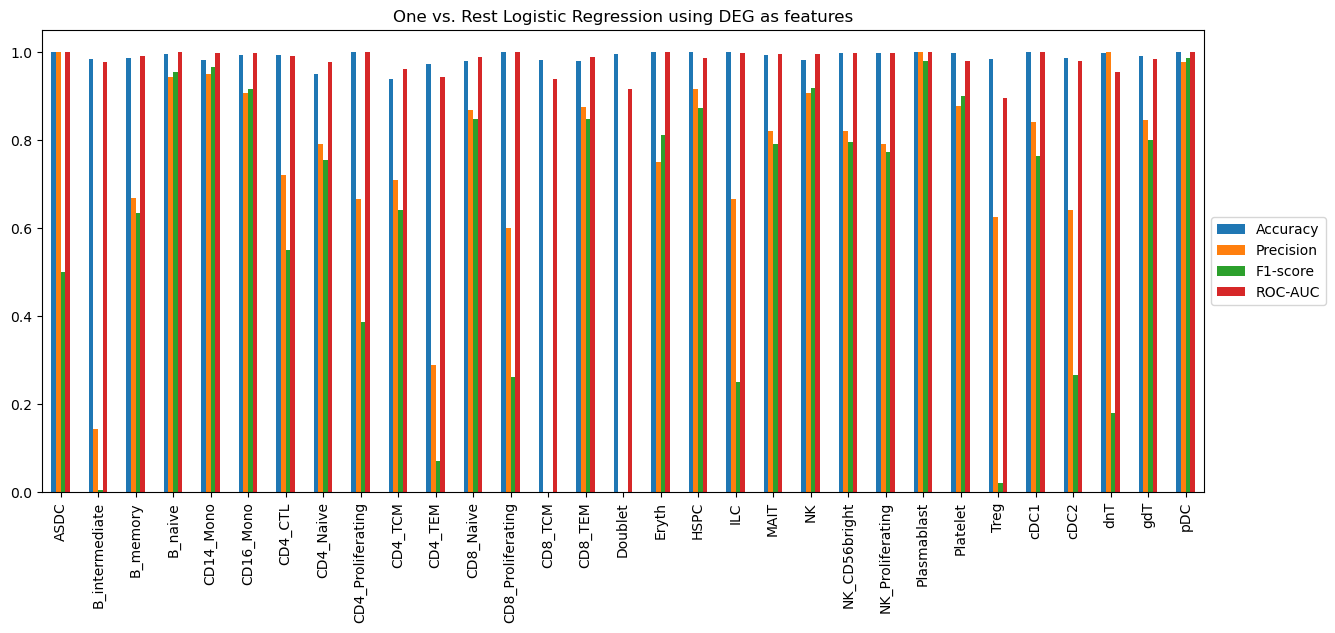

In [15]:
# Plot metrics for each celltype
ax = all_metrics.plot.bar(rot=0, figsize=(15, 6), title='One vs. Rest Logistic Regression using DEG as features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Rotate x-ticks by 90 degrees
plt.xticks(rotation=90)
plt.show()


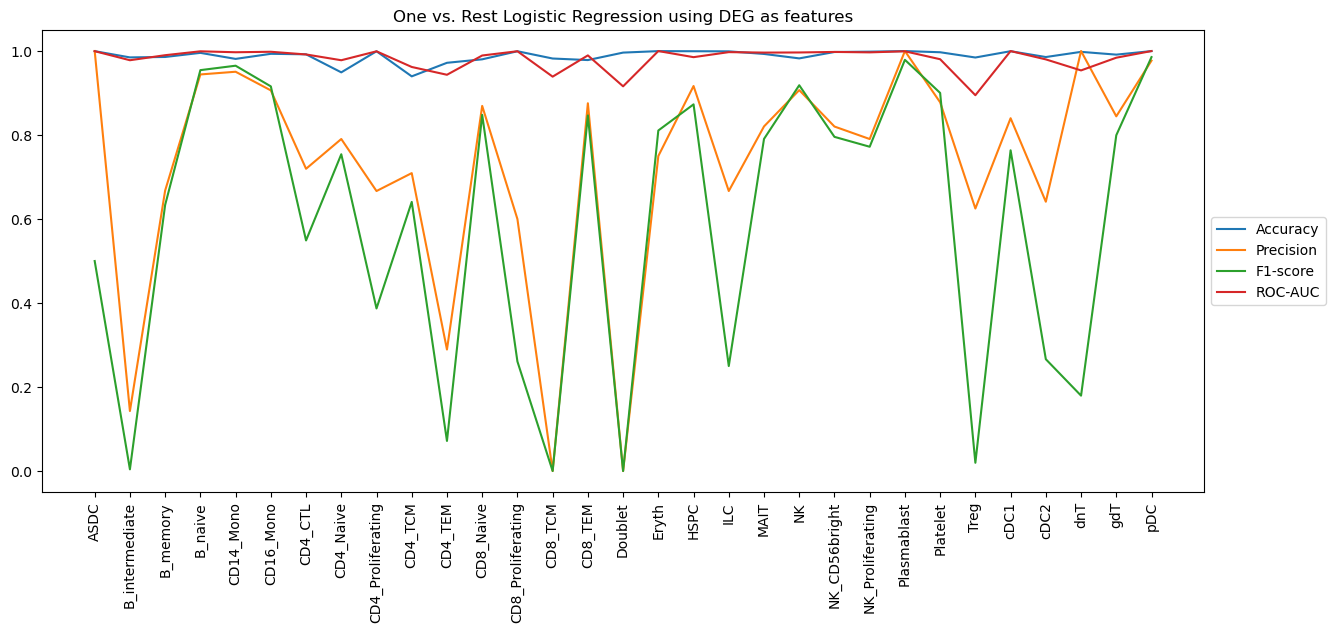

In [16]:
# line graph

# Plot metrics for each celltype
ax = all_metrics.plot.line(rot=0, figsize=(15, 6), title='One vs. Rest Logistic Regression using DEG as features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Generate x-ticks for every data point
plt.xticks(np.arange(len(all_metrics.index)), all_metrics.index, rotation=90)

plt.show()

## Plot metrics of LR classifier using ADlasso features
ADlasso features (converge by weight difference)
(2023/11/07 Progress Page.11)

In [17]:
# ad_metrics = pd.read_csv(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Level2_pvl0_ttsplit\lambda_decision_ignore_section\classifiers_all\L2_Kfold_metrics.csv", index_col=0)
ad_metrics = pd.read_csv('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level2_pvl0_ttsplit/lambda_decision_ignore_section/classifiers_all/L2_Kfold_metrics.csv', index_col=0)

In [18]:
ad_metrics.head()

,Accuracy,Precision,F1-score,ROC-AUC
ASDC,0.999839,0.887302,0.806079,0.999257
B_intermediate,0.987865,0.656598,0.504947,0.989570
B_memory,0.994133,0.877277,0.851316,0.998052
B_naive,0.995704,0.951072,0.955166,0.999426
CD14_Mono,0.987216,0.967987,0.975982,0.998321


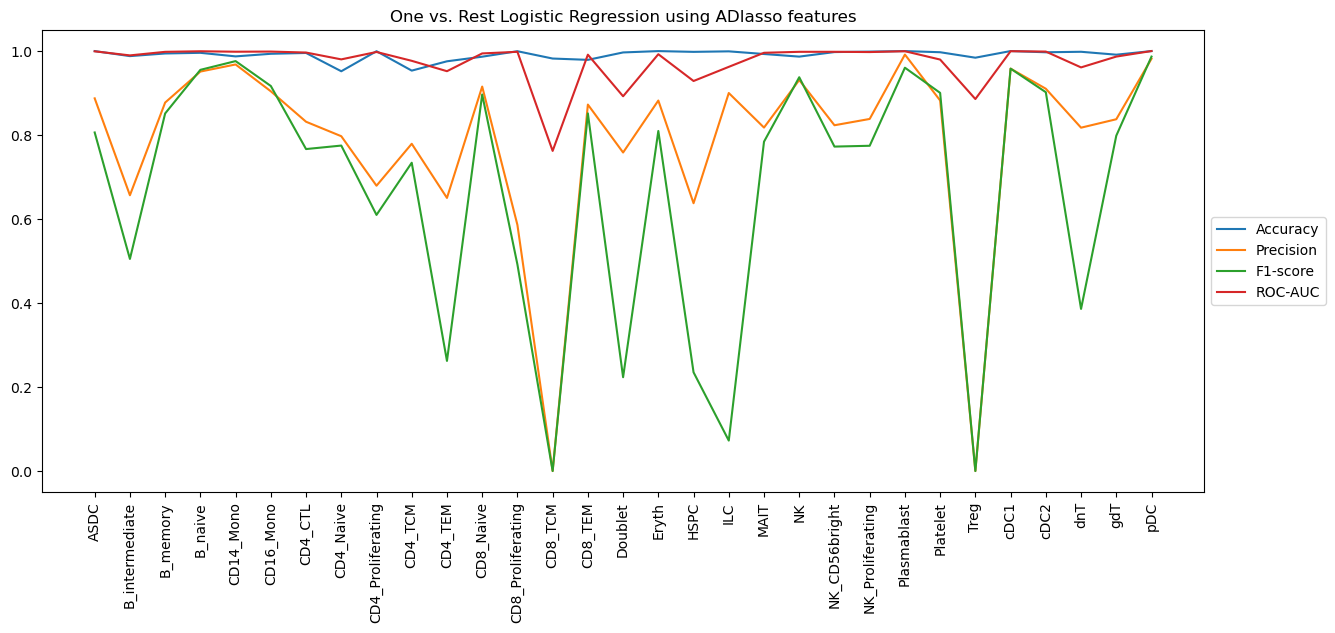

In [19]:
# line graph

# Plot metrics for each celltype
ax = ad_metrics.plot.line(rot=0, figsize=(15, 6), title='One vs. Rest Logistic Regression using ADlasso features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Generate x-ticks for every data point
plt.xticks(np.arange(len(ad_metrics.index)), ad_metrics.index, rotation=90)

plt.show()

In [20]:
all_metrics.columns

Index(['Accuracy', 'Precision', 'F1-score', 'ROC-AUC'], dtype='object')

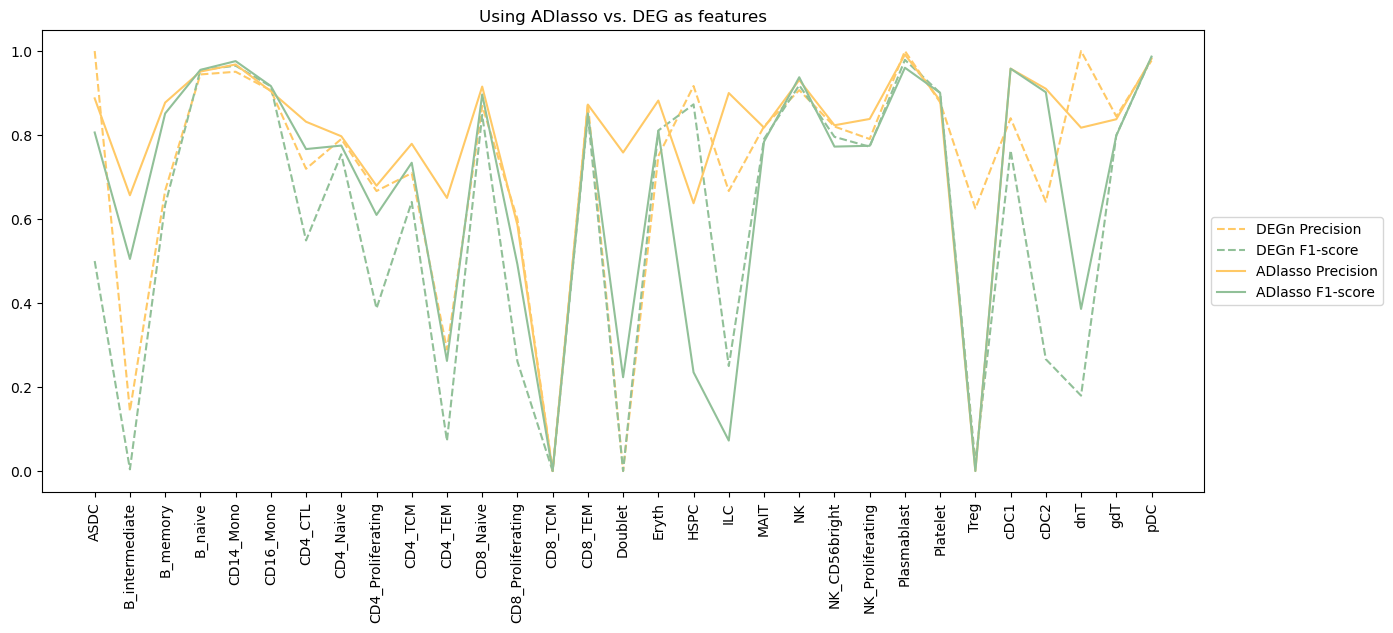

In [25]:
# Overlap two plots
# ADlasso metrics (line) vs. DEG metrics (dotted line)
selected_metrics = all_metrics[['Precision', 'F1-score']]
ax = selected_metrics.plot.line(rot=0, figsize=(15, 6), title='Using ADlasso vs. DEG as features', color=['#ffc966', '#91c098'], linestyle='dashed')
ad_metrics[['Precision', 'F1-score']].plot.line(ax=ax, rot=0, color=['#ffc966', '#91c098'])

ax.legend(['DEGn Precision','DEGn F1-score','ADlasso Precision','ADlasso F1-score'], loc='center left', bbox_to_anchor=(1.0, 0.5))

# Generate x-ticks for every data point
plt.xticks(np.arange(len(selected_metrics.index)), selected_metrics.index, rotation=90)

plt.show()

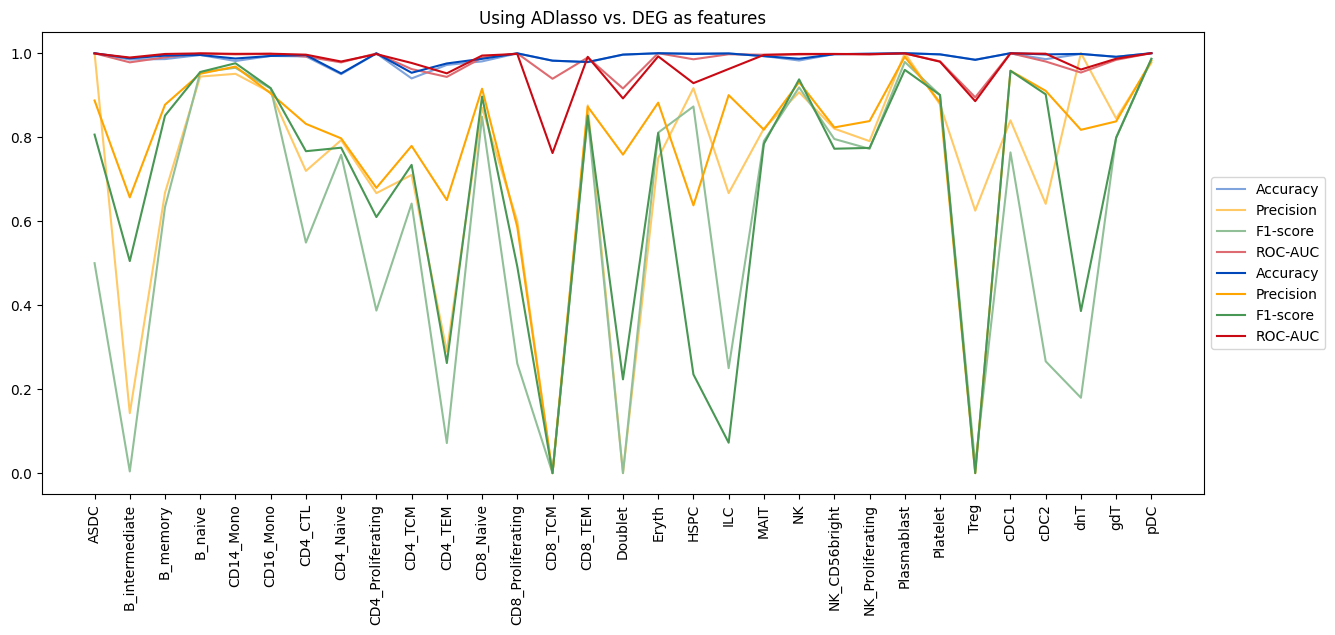

In [36]:
# Overlap two plots
# ADlasso metrics (深色) vs. DEG metrics (浅色)
# darker color: ['#0048ba', '#ffa500', '#489754', '#c90913']
# lighter color: ['#7fa3dc', '#ffc966', '#91c098', '#de6b71']

# Plot metrics for each celltype
ax = all_metrics.plot.line(rot=0, figsize=(15, 6), title='Using ADlasso vs. DEG as features', color=['#7fa3dc', '#ffc966', '#91c098', '#de6b71'])
ad_metrics.plot.line(ax=ax, rot=0, color=['#0048ba', '#ffa500', '#489754', '#c90913'])

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Generate x-ticks for every data point
plt.xticks(np.arange(len(all_metrics.index)), all_metrics.index, rotation=90)

plt.show()